In [0]:
pip install prophet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
pip install xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 

In [0]:
oil_df = pd.read_csv('/Volumes/workspace/default/timeseries/oil.csv')
holidays_df = pd.read_csv('/Volumes/workspace/default/timeseries/holidays_events.csv')
stores_df = pd.read_csv('/Volumes/workspace/default/timeseries/stores.csv')
transactions_df = pd.read_csv('/Volumes/workspace/default/timeseries/transactions.csv')
items_df = pd.read_csv('/Volumes/workspace/default/timeseries/items.csv')

In [0]:
display(stores_df.head())

store_nbr,city,state,type,cluster
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [0]:
# Load datasets
trains_df = pd.read_csv('/Volumes/workspace/default/timeseries/train.csv')

In [0]:
display(trains_df.head())

id,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [0]:
df = pd.read_csv('/Volumes/workspace/default/timeseries/train2.csv')

In [0]:
display(df.head())

store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
24,105574,2013-01-02,18790.0,12.0,false,2013,1,2,2,null
24,105574,2013-01-03,59692.0,1.0,false,2013,1,3,3,null
24,105574,2013-01-04,99664.0,3.0,false,2013,1,4,4,null
24,105574,2013-01-05,140805.0,4.0,false,2013,1,5,5,null
24,105574,2013-01-06,182800.0,7.0,false,2013,1,6,6,null


In [0]:
#df = df.drop(['unit_sales_7d_avg'], axis=1)

In [0]:
df.isnull().sum()

store_nbr                0
item_nbr                 0
date                     0
id                       0
unit_sales               0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
unit_sales_7d_avg    29995
dtype: int64

## Analysis

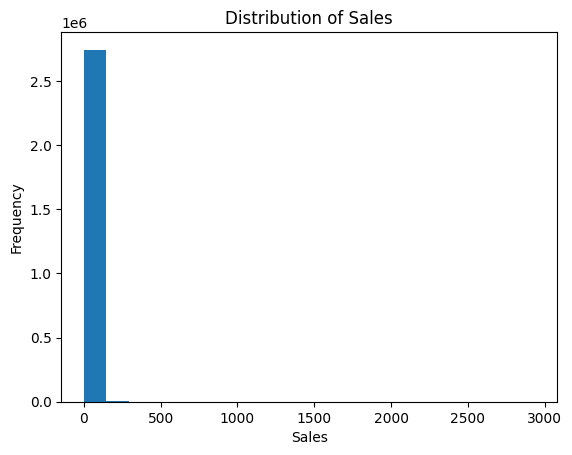

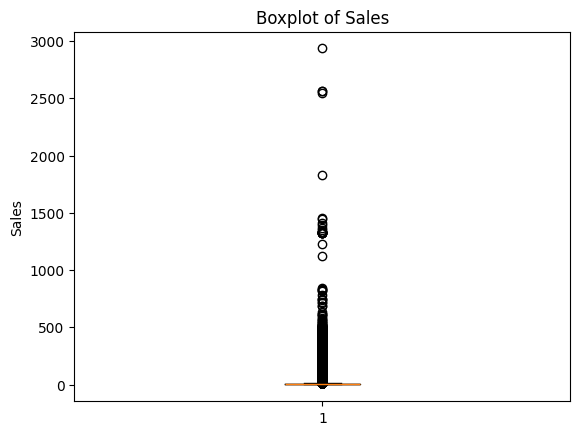

In [0]:
# Histogram
plt.hist(df['unit_sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(df['unit_sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

In [0]:
# Group the data by date and calculate the total sales
daily_sales = df.groupby('date')['unit_sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='unit_sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

/home/spark-9b829dec-c429-4038-bd85-4d/.ipykernel/3184/command-7180925390137602-2981729991:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




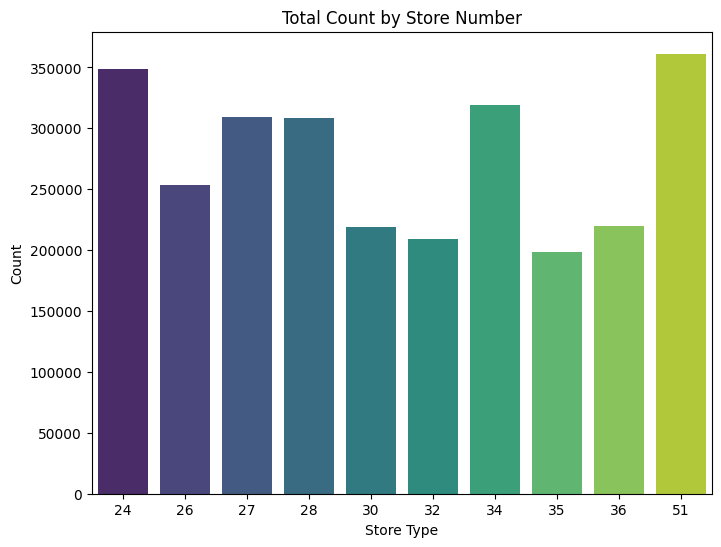

In [0]:
sns.set_palette("viridis")

# Calculate the total count and total sales per store type
store_type_counts = df['store_nbr'].value_counts()
store_type_sales = df.groupby('store_nbr')['unit_sales'].sum()

# Create a bar plot with unique colors for each bar
plt.figure(figsize=(8, 6))
colors = sns.color_palette("viridis", n_colors=len(store_type_counts))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values, palette=colors)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Number')
plt.show()

/home/spark-9b829dec-c429-4038-bd85-4d/.ipykernel/3184/command-7180925390137603-513077001:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




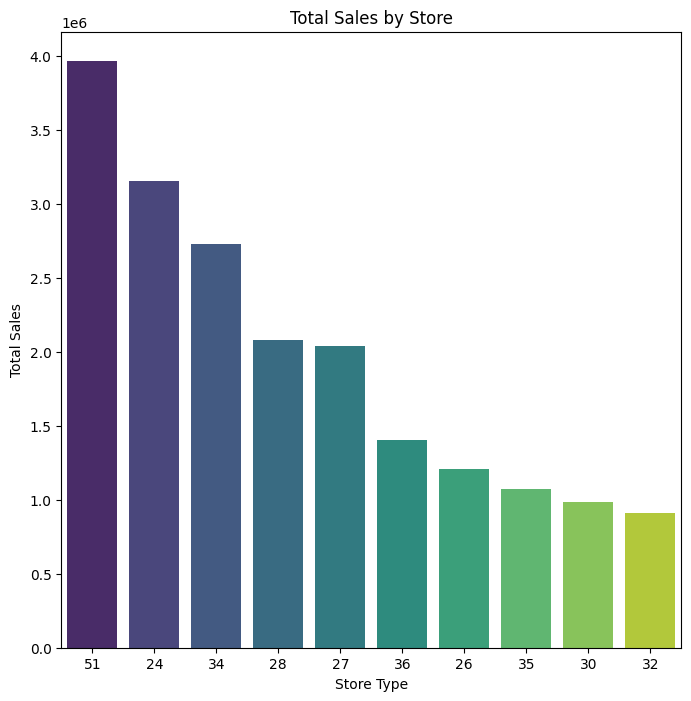

In [0]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.show()

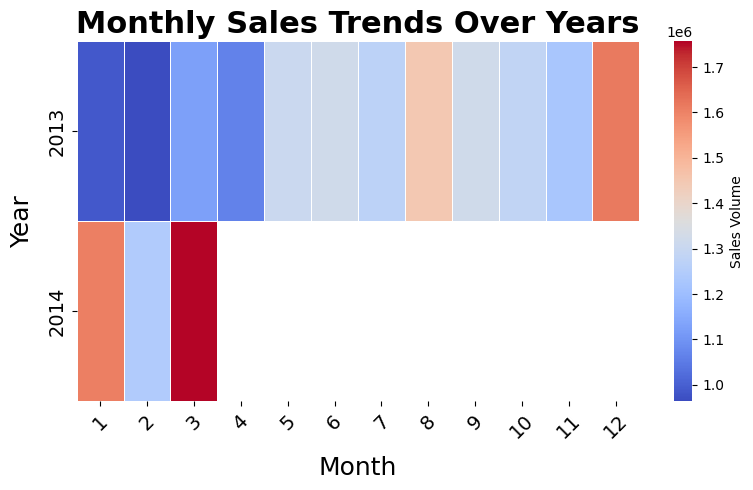

In [0]:
# Aggregating sales by year and month
sales_by_month = df.groupby(['year', 'month'])['unit_sales'].sum().unstack()

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

/home/spark-9b829dec-c429-4038-bd85-4d/.ipykernel/3184/command-7180925390137607-1551014480:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/home/spark-9b829dec-c429-4038-bd85-4d/.ipykernel/3184/command-7180925390137607-1551014480:4: UserWarning:

The palette list has more values (10) than needed (7), which may not be intended.



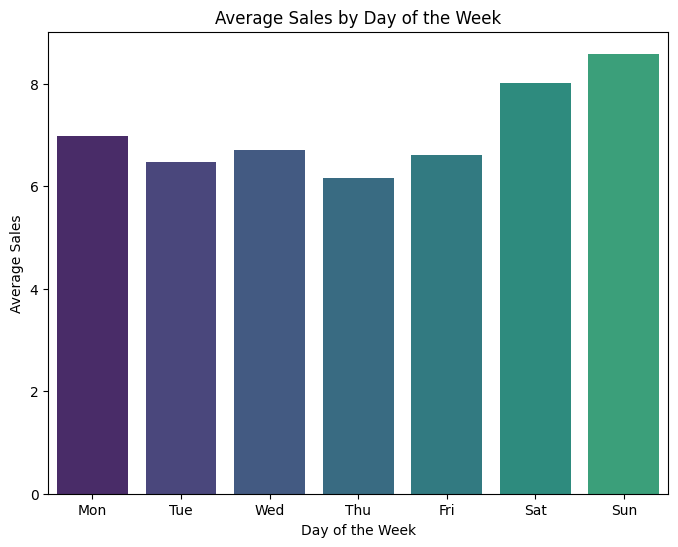

In [0]:
# Visualize the Day of the Week Sales Pattern
day_of_week_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=day_of_week_sales, x='day_of_week', y='unit_sales', palette=colors)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [0]:
display(df.head())

store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
24,105574,2013-01-02,18790.0,12.0,false,2013,1,2,2,null
24,105574,2013-01-03,59692.0,1.0,false,2013,1,3,3,null
24,105574,2013-01-04,99664.0,3.0,false,2013,1,4,4,null
24,105574,2013-01-05,140805.0,4.0,false,2013,1,5,5,null
24,105574,2013-01-06,182800.0,7.0,false,2013,1,6,6,null


In [0]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

num_cols = ['unit_sales']

# fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Display the updated dataframe
df.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,0.347015,False,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,-0.434269,False,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,-0.292217,False,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,-0.221192,False,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,-0.008114,False,2013,1,6,6,NaN


In [0]:
# Lag features (per store and item)

# Yesterday's sales, grouped by separate combinations of store-item (each item in each store has its own history)
df['lag_1'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
# Example: Yesterday had $100 in sales, today we will probably also see $100 in sales

# Last week's sales, similar to above
df['lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
# Example: Last Thursday had high milk sales, this Thursday will also see high milk sales

# Last month's sales, similar to above
df['lag_30'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(30)
# Example: Last month saw good sales in vegetables, this month will see the same

In [0]:
# Rolling statistics - standard deviation over last 7 days
df['rolling_std_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(window=7).std()

In [0]:
# Creates a new weekend variable and classifies it as 5 = Saturday and 6 = Sunday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [0]:
df_copy = df.copy()

In [0]:
len(df_copy)

2747123

In [0]:
split_date = '2014-01-01'

train_set = df[df['date'] <= split_date]
eval_set = df[df['date'] > split_date] 

In [0]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('unit_sales', axis=1)
X_train = train_set.drop('date', axis=1)   
y_train = train_set['unit_sales'] 


X_eval = eval_set.drop('unit_sales', axis=1)  
X_eval = eval_set.drop('date', axis=1)
y_eval = eval_set['unit_sales']

In [0]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE', 'Training Time'])

##ARIMA

In [0]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
start = time.time()
arima_model_fit = arima_model.fit()
arima_time = time.time() - start

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae],
                            'Training Time': [arima_time]}).round(2)

# Print the results_arima dataframe
results_arima

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/databrick

,Model,RMSLE,RMSE,MSE,MAE,Training Time
0,ARIMA,0.43,0.98,0.95,0.46,73.64


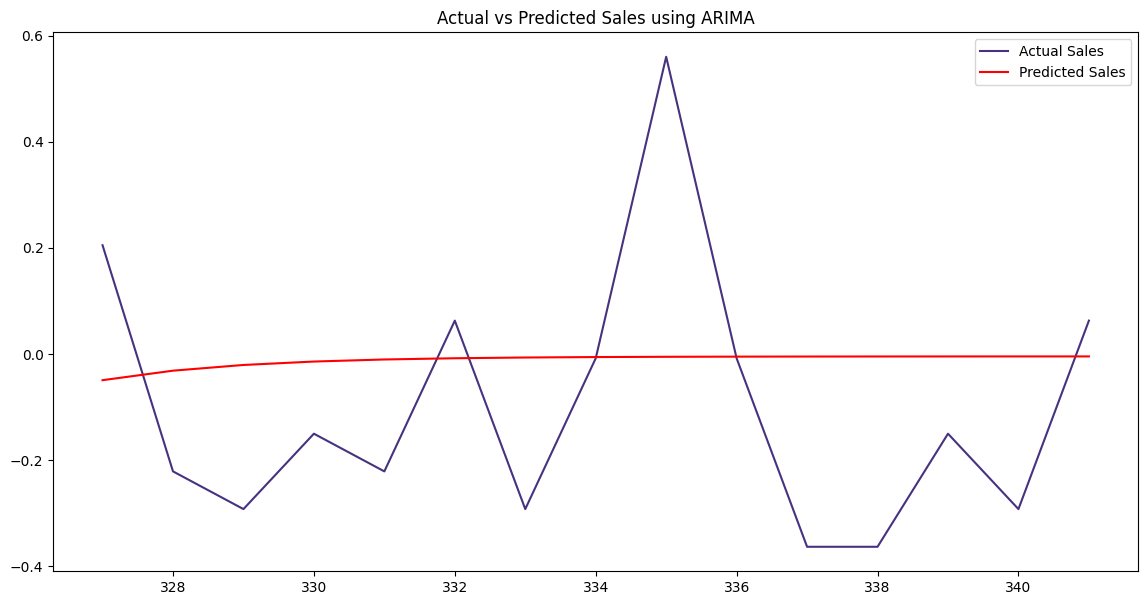

In [0]:
# Providing an updated plot
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_eval.index[:i], y_eval.values[:i], label='Actual Sales')
plt.plot(y_eval.index[:i], arima_predictions[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using ARIMA')
plt.legend()
plt.show()

##XGBoost

In [0]:
# Initialize the model
xgboost_model = xgb.XGBRegressor()

# Fit the model
start = time.time()
xgboost_model.fit(X_train, y_train)
xgb_time = time.time() - start

# Make predictions on the final validation set
xgboost_pred = xgboost_model.predict(X_eval)

# Calculate evaluation metrics
xgb_mse = mean_squared_error(y_eval, xgboost_pred)
xgb_rmse = np.sqrt(xgb_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
xgboost_pred_abs = abs(xgboost_pred)

# Calculate the Mean Absolute Error (MAE)
xgb_mae = mean_absolute_error(y_eval, xgboost_pred)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, xgboost_pred_abs))

# Create a DataFrame to store results for ARIMA
results_xgboost = pd.DataFrame({'Model': ['XGBoost'],
                            'RMSLE': [xgb_rmsle],
                            'RMSE': [np.sqrt(xgb_mse)],
                            'MSE': [xgb_mse],
                            'MAE': [xgb_mae],
                            'Training Time': [xgb_time]}).round(2)

results_xgboost

,Model,RMSLE,RMSE,MSE,MAE,Training Time
0,XGBoost,0.03,0.41,0.17,0.02,6.53


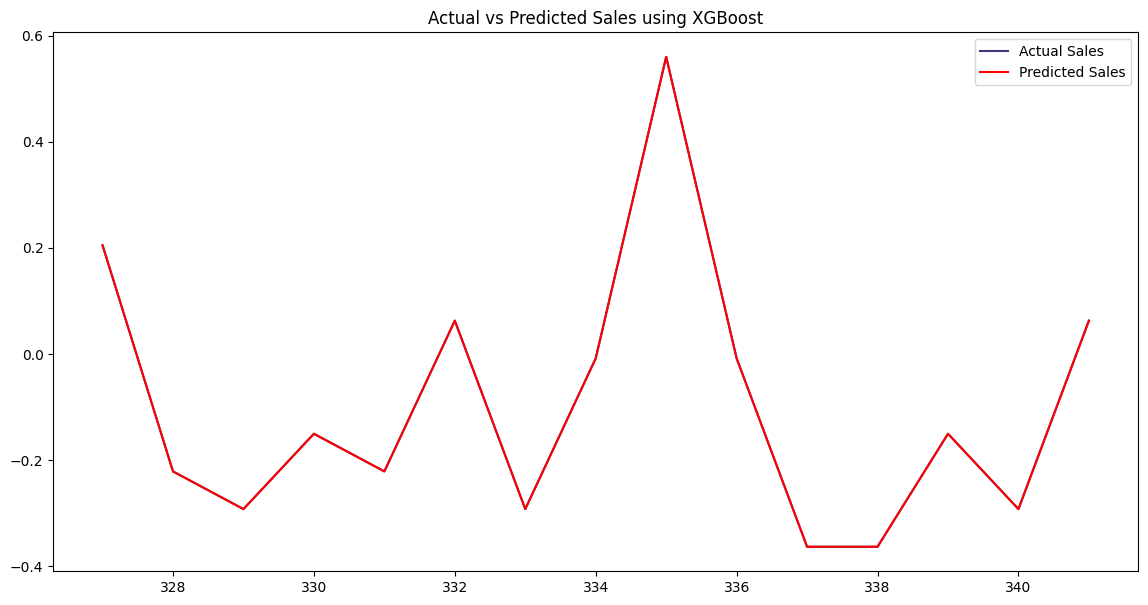

In [0]:
# Providing an updated plot
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_eval.index[:i], y_eval.values[:i], label='Actual Sales')
plt.plot(y_eval.index[:i], xgboost_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

##Exponential Smoothing (Holt-Winters)

In [0]:
# Create and Fit the Model
# trend='add' and seasonal='add' are standard for linear growth
# 'seasonal_periods' should be set based on your data frequency (e.g., 7 for daily data with weekly patterns)
hw_model = ExponentialSmoothing(y_train, 
                                trend='add', 
                                seasonal='add', 
                                seasonal_periods=7) 

start = time.time()
hw_model_fit = hw_model.fit()
hw_time = time.time() - start

# Make Predictions
# We predict for the length of the evaluation set
hw_predictions = hw_model_fit.forecast(len(y_eval))

# Calculate evaluation metrics
hw_mse = mean_squared_error(y_eval, hw_predictions)
hw_rmse = np.sqrt(hw_mse)
hw_mae = mean_absolute_error(y_eval, hw_predictions)

# Handle RMSLE (using absolute values to ensure positivity)
y_eval_abs = abs(y_eval)
hw_predictions_abs = abs(hw_predictions)
hw_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, hw_predictions_abs))

# 5. Create Results DataFrame
results_hw = pd.DataFrame({
    'Model': ['Holt-Winters'],
    'RMSLE': [hw_rmsle],
    'RMSE': [hw_rmse],
    'MSE': [hw_mse],
    'MAE': [hw_mae],
    'Training Time': [hw_time]
}).round(2)

results_hw

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul

/databricks/python/lib/python3.12/site-packages/sta

,Model,RMSLE,RMSE,MSE,MAE,Training Time
0,Holt-Winters,7.29,2948.84,8695643.37,2553.83,450.48


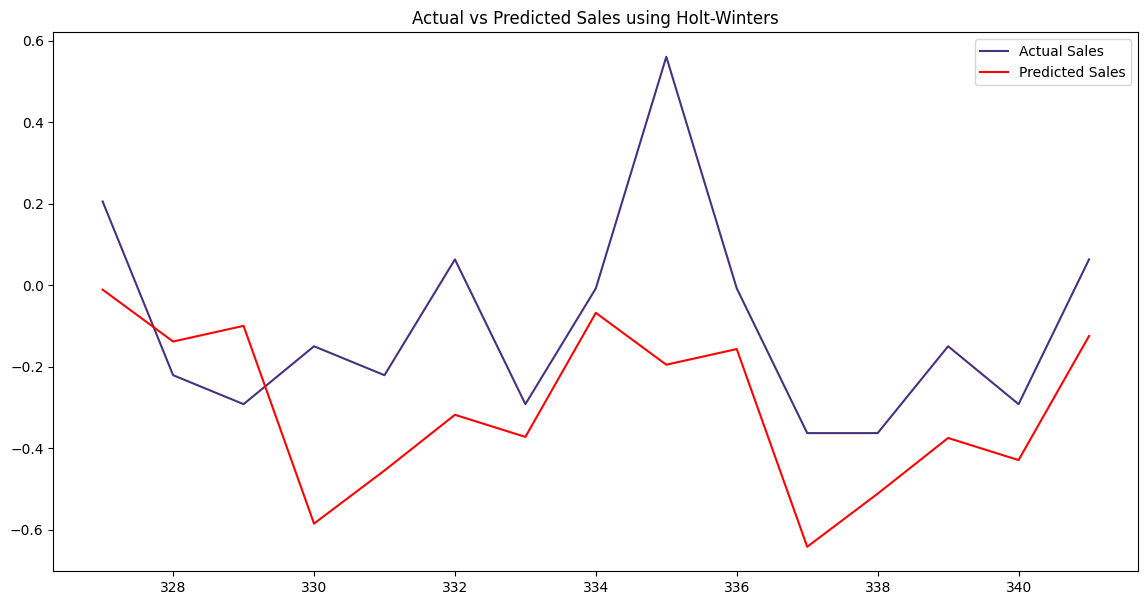

In [0]:
# Providing an updated plot
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_eval.index[:i], y_eval.values[:i], label='Actual Sales')
plt.plot(y_eval.index[:i], hw_predictions[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using Holt-Winters')
plt.legend()
plt.show()

##Prophet

In [0]:
# Convert 'date' column to datetime format
df_copy['date'] = pd.to_datetime(df_copy['date'])

# Aggregate sales by date (sum all sales for each day)
daily_sales = df_copy.groupby('date')['unit_sales'].sum().reset_index()

# Rename columns to Prophet's required format
# 'ds' = datestamp, 'y' = the value we want to forecast
prophet_df = daily_sales.rename(columns={'date': 'ds', 'unit_sales': 'y'})

print("✅ Data prepared for Prophet!")
print(f"\n📅 Date range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")
print(f"📏 Total days: {len(prophet_df)} days")
print("\n👀 Prepared data:")
prophet_df.head(10)

✅ Data prepared for Prophet!

📅 Date range: 2013-01-02 00:00:00 to 2014-03-31 00:00:00
📏 Total days: 453 days

👀 Prepared data:


,ds,y
0,2013-01-02,419.209400
1,2013-01-03,-112.913296
2,2013-01-04,-201.495007
3,2013-01-05,339.048114
4,2013-01-06,474.518666
5,2013-01-07,-241.108983
6,2013-01-08,-295.267376
7,2013-01-09,-184.619422
8,2013-01-10,-490.146580
9,2013-01-11,-352.295491


In [0]:
# Create Prophet model

model_advanced = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,    
    yearly_seasonality=False,   
    seasonality_mode='additive'
)

# Add yearly seasonality
model_advanced.add_seasonality(
    name='yearly_custom',
    period=365.25,              # Length of the cycle (days in a year)
    fourier_order=20,           # Higher order = more complex patterns
    prior_scale=10              # How much to weight this component
)

# Add weekly seasonality 
model_advanced.add_seasonality(
    name='weekly_custom',
    period=7,                   # Length of the cycle (7 days)
    fourier_order=5,            # Higher order for complex weekly patterns
    prior_scale=10
)

# Add monthly seasonality 
model_advanced.add_seasonality(
    name='monthly_custom',
    period=30.5,                # Approximate days in a month
    fourier_order=8,            # Capture monthly patterns
    prior_scale=10
)

# Train the model
model_advanced.fit(prophet_df)


🔧 Creating Advanced Prophet model with custom Fourier seasonality...



09:11:17 - cmdstanpy - INFO - Chain [1] start processing
09:11:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Advanced Prophet model trained successfully!


In [0]:
future_days = 60

# Create future dates (same as before)
print(f"📅 Creating dates for the next {future_days} days...\n")

future_advanced = model_advanced.make_future_dataframe(periods=future_days, freq='D')

print("🔮 Generating predictions with advanced model...\n")

# Generate predictions
forecast_advanced = model_advanced.predict(future_advanced)

print("✅ Advanced predictions complete!")

# Display predictions
print(f"\n🔍 Last {min(10, future_days)} predictions (Advanced Model):")
forecast_advanced[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

📅 Creating dates for the next 60 days...

🔮 Generating predictions with advanced model...

✅ Advanced predictions complete!

🔍 Last 10 predictions (Advanced Model):


,ds,yhat,yhat_lower,yhat_upper
503,2014-05-21,82.780371,-223.115117,363.597828
504,2014-05-22,-250.735362,-557.538370,29.630798
505,2014-05-23,-108.907195,-414.555279,201.064875
506,2014-05-24,545.780639,242.393463,869.667971
507,2014-05-25,813.642186,513.094825,1109.301480
508,2014-05-26,29.292103,-245.795203,348.649414
509,2014-05-27,-178.948715,-475.487839,113.529643
510,2014-05-28,-21.725450,-333.525202,282.617435
511,2014-05-29,-265.603281,-553.091393,36.760109
512,2014-05-30,-86.150690,-403.033400,221.688787


In [0]:
# This cuts the data and simulates forecasts at different points in time
df_cv = cross_validation(model_advanced, initial='300 days', period='365 days', horizon='90 days')
df_p = performance_metrics(df_cv)

df_p

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

09:11:18 - cmdstanpy - INFO - Chain [1] start processing
09:11:18 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,235281.558779,485.058305,410.175536,3.399267,0.912730,1.225037,0.333333
1,10 days,189738.926955,435.590320,340.866131,2.878638,0.683716,1.009338,0.444444
2,11 days,166305.781767,407.806059,305.422152,2.829871,0.574031,0.891782,0.555556
3,12 days,192583.176199,438.842997,349.495322,2.813568,0.536988,0.857919,0.444444
4,13 days,164635.049590,405.752449,313.421531,6.171023,0.574031,0.988695,0.555556
...,...,...,...,...,...,...,...,...
77,86 days,45375.429988,213.015093,194.629266,1.495182,1.344316,0.885652,0.888889
78,87 days,42584.143205,206.359258,187.244103,1.028317,0.565388,0.712405,0.888889
79,88 days,60671.257790,246.315362,213.339627,0.969847,0.565388,0.776896,0.777778
80,89 days,73417.653809,270.956922,244.852739,0.983273,0.565388,0.820707,0.666667


/local_disk0/.ephemeral_nfs/envs/pythonEnv-9b829dec-c429-4038-bd85-4de5281db2ab/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9b829dec-c429-4038-bd85-4de5281db2ab/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



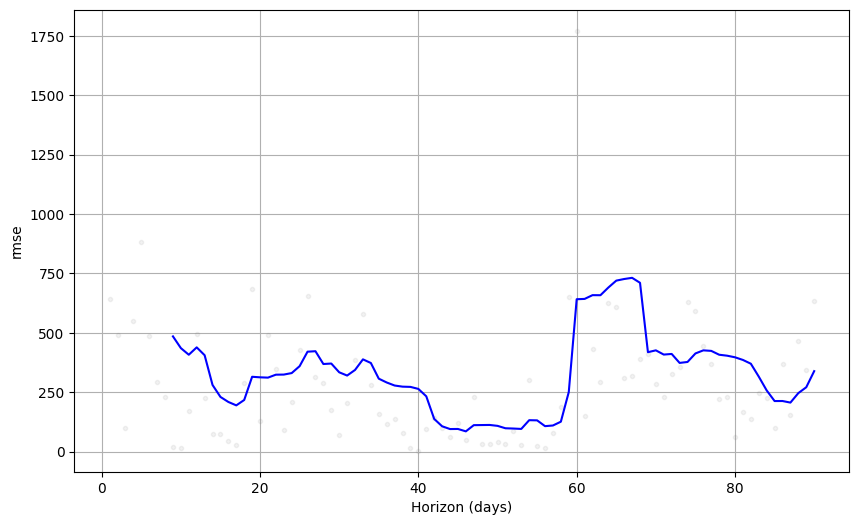

In [0]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

##Comparison

In [0]:
# Append all results to the results dataframe
results_df = pd.concat([results_df, results_xgboost, results_arima, results_hw], ignore_index=True)

# Reset the index of the DataFrame
results_df = results_df.reset_index(drop=True)

# Print the Final Results dataframe
results_df

/home/spark-9b829dec-c429-4038-bd85-4d/.ipykernel/3184/command-7180925390137669-985613447:2: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Model,RMSLE,RMSE,MSE,MAE,Training Time
0,XGBoost,0.03,0.41,0.17,0.02,6.53
1,ARIMA,0.43,0.98,0.95,0.46,73.64
2,Holt-Winters,7.29,2948.84,8695643.37,2553.83,450.48
